In [ ]:
# ..... expressolog score across stages ..... #

In [1]:
# specificity calculation
calc_spec <- function (res, np, nL){    
  
  ranks = 1:nL
  mini = sum(ranks[1:np])
  range = np*(nL - np)
  
  temp1 = t(apply(res, 1, function(x) rank(x, ties.method = "average")))      
  spec1 <- (temp1 - mini)/range   
  temp2 = t(apply(t(res), 1, function(x) rank(x, ties.method = "average")))      
  spec2 <- (temp2 - mini)/range
  spec = 0.5*(spec1 + t(spec2))
  
  return(diag(spec))  # return full matrix
}  

In [12]:
# load pseudobulk data
path1 = 'stage13'
path2 = 'stage16'
load(paste0(path2, '_pseudobulk_expression_matrices.Rdata'))
scbulk2 = scbulk1
load(paste0(path1, '_pseudobulk_expression_matrices.Rdata'))
ls()

[1] "calc_spec"    "combos"       "common_genes" "common_types" "fullcorr"    
 [6] "fullcorrspec" "mat1"         "mat2"         "newdf"        "path1"       
[11] "path2"        "scbulk1"      "scbulk2"      "stages"

In [13]:
mat1 = scbulk1
mat2 = scbulk2

# remove low-expr genes
common_genes = intersect(rownames(mat1)[rowSums(mat1)>5], rownames(mat2)[rowSums(mat2)>5])
mat1 <- mat1[common_genes,]
mat2 <- mat2[common_genes,]

# keep common cell types
common_types = intersect(colnames(scbulk1), colnames(scbulk2))
mat1 <- mat1[,common_types]
mat2 <- mat2[,common_types]

In [14]:
# correlate across all subclasses
options(warn = -1)
fullcorr = cor(t(mat1), t(mat2), method = 'pearson')

# specificity scores
fullcorrspec = calc_spec(fullcorr, 1, dim(fullcorr)[1])

# save
newdf = data.frame(gene = common_genes, expressolog = fullcorrspec)
write.table(newdf, file = paste0(path1, '_', path2, '_expressolog.csv'), sep = ',',
                                row.names = F, col.names = T, quote = F)

gene         expressolog
LOC132761864 LOC132761864 0.2450677  
LOC132781058 LOC132781058 0.1995097  
LOC132781659 LOC132781659 0.7710717  
LOC132781291 LOC132781291 0.3558837  
LOC132781595 LOC132781595 0.2379465  
LOC132781507 LOC132781507 0.1311289

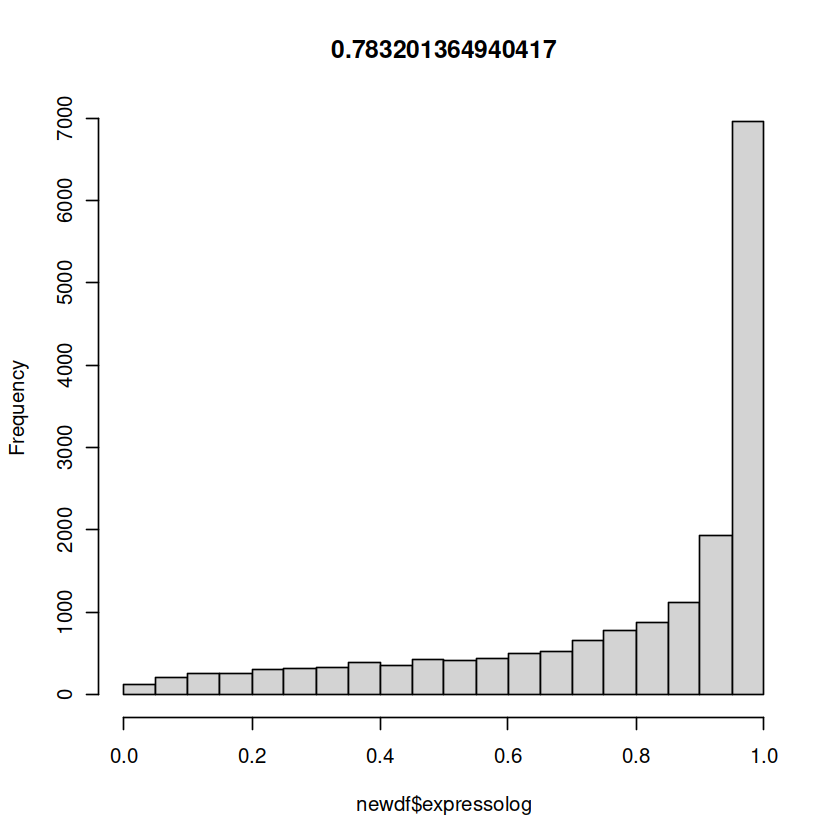

In [15]:
head(newdf)
hist(newdf$expressolog, main = mean(newdf$expressolog, na.rm = T))

In [16]:
# plot distributions of scores
library(ggplot2)
library(ggridges)
library(corrplot)
stages = c('stage9', 'stage13', 'stage16')
combos = combn(length(stages),2)
combos

[,1] [,2] [,3]
[1,] 1    1    2   
[2,] 2    3    3

In [17]:
newdf = c()
corrmat = matrix(NA, nrow = 3, ncol = 3)
for(ii in 1:dim(combos)[2]){
    df1 = read.delim(paste0(stages[combos[1,ii]], '_', stages[combos[2,ii]], '_expressolog.csv'), sep = ',')
    df1$stage = paste0(stages[combos[1,ii]], '_', stages[combos[2,ii]])
    corrmat[combos[1,ii], combos[2,ii]] = mean(df1$expressolog, na.rm = T)
    corrmat[combos[2,ii], combos[1,ii]] = mean(df1$expressolog, na.rm = T)
    newdf = rbind(newdf, df1)
}
newdf[1,]
rownames(corrmat) = stages
colnames(corrmat) = stages
corrmat

gene         expressolog stage         
1 LOC132761864 0.6352498   stage9_stage13

stage9    stage13   stage16  
stage9         NA 0.7921987 0.7837685
stage13 0.7921987        NA 0.7832014
stage16 0.7837685 0.7832014        NA

Loading required package: viridisLite



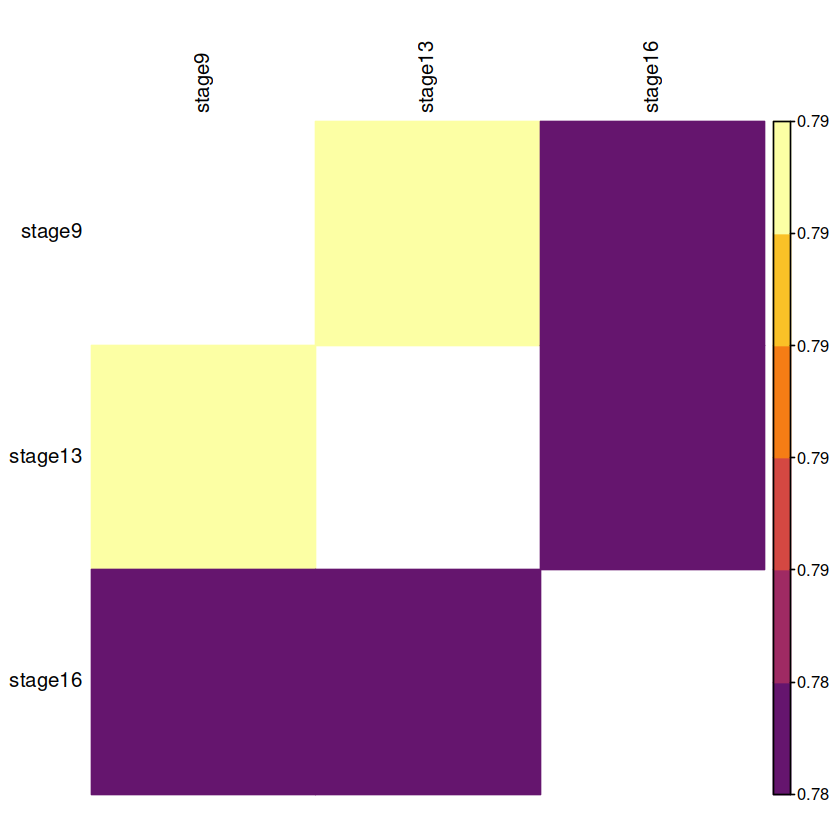

In [18]:
# ggplot(newdf, aes(x = stage, y = expressolog)) + geom_boxplot()
library(viridis)
my_palette = viridis::inferno(8)
# png('aa-human-mouse.png', width = 5, height = 5, res = 300, units = 'in')
# pdf('aa-chicken-3x3.pdf', width = 5, height = 5)
corrplot(corrmat, method = 'color', is.corr = F, col = my_palette[3:8], #col.lim = c(0.7,1),
         tl.col = 'black', na.label = ' ', na.label.col = 'white')
# dev.off()